In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import DenseNet201
from keras.applications import DenseNet121

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [3]:
train_dir = 'data/bioimaging/train/'
test_dir = "data/bioimaging/test/"

extracted_features_dir = "extracted_features/"
model_name = "bioimaging_InceptionResNetV2"

In [4]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.10.0
dim_ordering: tf


In [5]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/bioimaging/train/ 0
data/bioimaging/train/carcinoma 5696
data/bioimaging/train/non-carcinoma 5696
******************************
data/bioimaging/test/ 0
data/bioimaging/test/carcinoma 36
data/bioimaging/test/non-carcinoma 35


In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 8544 images belonging to 2 classes.
Found 2848 images belonging to 2 classes.
Found 71 images belonging to 2 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 8544
nb_validation_samples: 2848

predict_size_train: 267
predict_size_validation: 89
nb_test_samples: 71
predict_size_test: 3

 num_classes: 2


In [9]:
# from keras.backend.tensorflow_backend import get_session
# from keras.backend.tensorflow_backend import clear_session
# from keras.backend.tensorflow_backend import set_session

# def reset_keras_tf_session():
#     """
#     this function clears the gpu memory and set the 
#     tf session to not use the whole gpu
#     """
#     sess = get_session()
#     clear_session()
#     sess.close()
#     sess = get_session()

# #     config = tf.ConfigProto()
# #     config.gpu_options.allow_growth = True
# #     set_session(tf.Session(config=config))


# reset_keras_tf_session()

In [10]:
# from keras.applications.mobilenetv2 import MobileNetV2
# from keras.applications.densenet import DenseNet169
# from keras.applications.vgg19 import VGG19
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.vgg16 import VGG16
# from keras.applications.xception import Xception, preprocess_input
# from keras.applications import DenseNet201
# from keras.applications import DenseNet121
# from keras.applications import ResNet50
from keras.applications.inception_resnet_v2 import InceptionResNetV2
# from keras.applications import NASNetLarge, NASNetMobile
# from keras.applications import MobileNet


input_tensor = Input(shape = input_shape)  
model = InceptionResNetV2(weights='imagenet', include_top=False, pooling = 'avg', input_tensor=input_tensor)
bottleneck_final_model = model

In [11]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [12]:
# c1 = model.layers[9].output 
# c1 = GlobalAveragePooling2D()(c1)       

# c2 = model.layers[55].output
# c2 = GlobalAveragePooling2D()(c2)       

# c3 = model.layers[143].output
# c3 = GlobalAveragePooling2D()(c3)       

# c4 = model.layers[483].output
# c4 = GlobalAveragePooling2D()(c4)

# con = concatenate([c1, c2, c3, c4])

# bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [13]:
# bottleneck_final_model.summary()

In [14]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [15]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [16]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [17]:
dropout_rate = 0.4

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.9, amsgrad=False)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 8544 samples, validate on 2848 samples
Epoch 1/1000
 - 3s - loss: 0.4949 - acc: 0.7530 - val_loss: 0.3186 - val_acc: 0.8803
Epoch 2/1000
 - 1s - loss: 0.2954 - acc: 0.8821 - val_loss: 0.2232 - val_acc: 0.9213
Epoch 3/1000
 - 1s - loss: 0.2147 - acc: 0.9206 - val_loss: 0.1772 - val_acc: 0.9505
Epoch 4/1000
 - 1s - loss: 0.1682 - acc: 0.9424 - val_loss: 0.1414 - val_acc: 0.9610
Epoch 5/1000
 - 1s - loss: 0.1381 - acc: 0.9533 - val_loss: 0.1284 - val_acc: 0.9638
Epoch 6/1000
 - 1s - loss: 0.1111 - acc: 0.9641 - val_loss: 0.1103 - val_acc: 0.9614
Epoch 7/1000
 - 1s - loss: 0.0905 - acc: 0.9731 - val_loss: 0.0931 - val_acc: 0.9684
Epoch 8/1000
 - 1s - loss: 0.0795 - acc: 0.9773 - val_loss: 0.0748 - val_acc: 0.9761
Epoch 9/1000
 - 1s - loss: 0.0678 - acc: 0.9805 - val_loss: 0.0749 - val_acc: 0.9740
Epoch 10/1000
 - 1s - loss: 0.0575 - acc: 0.9834 - val_loss: 0.0602 - val_acc: 0.9807
Epoch 11/1000
 - 1s - loss: 0.0496 - acc: 0.9874 - val_loss: 0.0552 - val_acc: 0.9789
Epoch 12/1000
 

Epoch 95/1000
 - 1s - loss: 9.3687e-04 - acc: 0.9996 - val_loss: 0.0146 - val_acc: 0.9961
Epoch 96/1000
 - 1s - loss: 3.4420e-04 - acc: 0.9999 - val_loss: 0.0140 - val_acc: 0.9961
Epoch 97/1000
 - 1s - loss: 4.0432e-04 - acc: 0.9999 - val_loss: 0.0121 - val_acc: 0.9968
Epoch 98/1000
 - 1s - loss: 0.0012 - acc: 0.9995 - val_loss: 0.0151 - val_acc: 0.9951
Epoch 99/1000
 - 1s - loss: 2.6690e-04 - acc: 1.0000 - val_loss: 0.0214 - val_acc: 0.9947
Epoch 100/1000
 - 1s - loss: 3.7399e-04 - acc: 0.9999 - val_loss: 0.0150 - val_acc: 0.9961
Epoch 101/1000
 - 1s - loss: 5.4260e-04 - acc: 0.9998 - val_loss: 0.0125 - val_acc: 0.9965
Epoch 102/1000
 - 1s - loss: 6.0350e-04 - acc: 0.9999 - val_loss: 0.0176 - val_acc: 0.9958
Epoch 103/1000
 - 1s - loss: 3.6106e-04 - acc: 0.9999 - val_loss: 0.0159 - val_acc: 0.9944
Epoch 104/1000
 - 1s - loss: 6.4613e-04 - acc: 0.9998 - val_loss: 0.0140 - val_acc: 0.9954
Epoch 105/1000
 - 1s - loss: 1.6402e-04 - acc: 1.0000 - val_loss: 0.0128 - val_acc: 0.9951
Epoch 10

Epoch 186/1000
 - 1s - loss: 3.9020e-05 - acc: 1.0000 - val_loss: 0.0148 - val_acc: 0.9968
Epoch 187/1000
 - 1s - loss: 5.6785e-05 - acc: 1.0000 - val_loss: 0.0136 - val_acc: 0.9954
Epoch 188/1000
 - 1s - loss: 1.0282e-05 - acc: 1.0000 - val_loss: 0.0160 - val_acc: 0.9972
Epoch 189/1000
 - 1s - loss: 2.0697e-05 - acc: 1.0000 - val_loss: 0.0156 - val_acc: 0.9965
Epoch 190/1000
 - 1s - loss: 5.9857e-05 - acc: 1.0000 - val_loss: 0.0150 - val_acc: 0.9968
Epoch 191/1000
 - 1s - loss: 3.0508e-05 - acc: 1.0000 - val_loss: 0.0194 - val_acc: 0.9961
Epoch 192/1000
 - 1s - loss: 3.3261e-04 - acc: 0.9998 - val_loss: 0.0242 - val_acc: 0.9947
Epoch 193/1000
 - 1s - loss: 3.7685e-05 - acc: 1.0000 - val_loss: 0.0158 - val_acc: 0.9968
Epoch 194/1000
 - 1s - loss: 1.2590e-05 - acc: 1.0000 - val_loss: 0.0156 - val_acc: 0.9954
Epoch 195/1000
 - 1s - loss: 5.9185e-05 - acc: 1.0000 - val_loss: 0.0132 - val_acc: 0.9968
Epoch 196/1000
 - 1s - loss: 6.7211e-06 - acc: 1.0000 - val_loss: 0.0144 - val_acc: 0.9975

 - 1s - loss: 3.0699e-05 - acc: 1.0000 - val_loss: 0.0157 - val_acc: 0.9975
Epoch 277/1000
 - 1s - loss: 2.0507e-06 - acc: 1.0000 - val_loss: 0.0145 - val_acc: 0.9968
Epoch 278/1000
 - 1s - loss: 5.6872e-07 - acc: 1.0000 - val_loss: 0.0128 - val_acc: 0.9968
Epoch 279/1000
 - 1s - loss: 1.7121e-06 - acc: 1.0000 - val_loss: 0.0137 - val_acc: 0.9975
Epoch 280/1000
 - 1s - loss: 1.2592e-05 - acc: 1.0000 - val_loss: 0.0188 - val_acc: 0.9947
Epoch 281/1000
 - 1s - loss: 1.2467e-05 - acc: 1.0000 - val_loss: 0.0140 - val_acc: 0.9965
Epoch 282/1000
 - 1s - loss: 9.9557e-06 - acc: 1.0000 - val_loss: 0.0156 - val_acc: 0.9972
Epoch 283/1000
 - 1s - loss: 9.6572e-07 - acc: 1.0000 - val_loss: 0.0137 - val_acc: 0.9961
Epoch 284/1000
 - 1s - loss: 1.2825e-05 - acc: 1.0000 - val_loss: 0.0131 - val_acc: 0.9975
Epoch 285/1000
 - 1s - loss: 4.0267e-06 - acc: 1.0000 - val_loss: 0.0150 - val_acc: 0.9968
Epoch 286/1000
 - 1s - loss: 8.2085e-05 - acc: 1.0000 - val_loss: 0.0155 - val_acc: 0.9961
Epoch 287/1000

Epoch 367/1000
 - 1s - loss: 4.1736e-06 - acc: 1.0000 - val_loss: 0.0132 - val_acc: 0.9975
Epoch 368/1000
 - 1s - loss: 2.6025e-07 - acc: 1.0000 - val_loss: 0.0130 - val_acc: 0.9968
Epoch 369/1000
 - 1s - loss: 5.6012e-07 - acc: 1.0000 - val_loss: 0.0136 - val_acc: 0.9979
Epoch 370/1000
 - 1s - loss: 2.9736e-07 - acc: 1.0000 - val_loss: 0.0159 - val_acc: 0.9975
Epoch 371/1000
 - 1s - loss: 3.2528e-07 - acc: 1.0000 - val_loss: 0.0147 - val_acc: 0.9961
Epoch 372/1000
 - 1s - loss: 3.3538e-07 - acc: 1.0000 - val_loss: 0.0157 - val_acc: 0.9972
Epoch 373/1000
 - 1s - loss: 3.0145e-07 - acc: 1.0000 - val_loss: 0.0141 - val_acc: 0.9972
Epoch 374/1000
 - 1s - loss: 8.1644e-06 - acc: 1.0000 - val_loss: 0.0125 - val_acc: 0.9972
Epoch 375/1000
 - 1s - loss: 4.4877e-07 - acc: 1.0000 - val_loss: 0.0136 - val_acc: 0.9972
Epoch 376/1000
 - 1s - loss: 4.1978e-07 - acc: 1.0000 - val_loss: 0.0136 - val_acc: 0.9968
Epoch 377/1000
 - 1s - loss: 7.2558e-07 - acc: 1.0000 - val_loss: 0.0147 - val_acc: 0.9972

 - 1s - loss: 1.4920e-07 - acc: 1.0000 - val_loss: 0.0133 - val_acc: 0.9982
Epoch 458/1000
 - 1s - loss: 1.4497e-06 - acc: 1.0000 - val_loss: 0.0147 - val_acc: 0.9968
Epoch 459/1000
 - 1s - loss: 4.7738e-06 - acc: 1.0000 - val_loss: 0.0175 - val_acc: 0.9975
Epoch 460/1000
 - 1s - loss: 1.6736e-07 - acc: 1.0000 - val_loss: 0.0140 - val_acc: 0.9965
Epoch 461/1000
 - 1s - loss: 8.2590e-07 - acc: 1.0000 - val_loss: 0.0138 - val_acc: 0.9975
Epoch 462/1000
 - 1s - loss: 1.5721e-07 - acc: 1.0000 - val_loss: 0.0154 - val_acc: 0.9975
Epoch 463/1000
 - 1s - loss: 1.6872e-07 - acc: 1.0000 - val_loss: 0.0171 - val_acc: 0.9979
Epoch 464/1000
 - 1s - loss: 1.9901e-07 - acc: 1.0000 - val_loss: 0.0141 - val_acc: 0.9968
Epoch 465/1000
 - 1s - loss: 2.4450e-06 - acc: 1.0000 - val_loss: 0.0133 - val_acc: 0.9982
Epoch 466/1000
 - 1s - loss: 7.1438e-07 - acc: 1.0000 - val_loss: 0.0137 - val_acc: 0.9975
Epoch 467/1000
 - 1s - loss: 1.1103e-05 - acc: 1.0000 - val_loss: 0.0147 - val_acc: 0.9968
Epoch 468/1000

Epoch 548/1000
 - 1s - loss: 2.2604e-07 - acc: 1.0000 - val_loss: 0.0135 - val_acc: 0.9972
Epoch 549/1000
 - 1s - loss: 1.3064e-07 - acc: 1.0000 - val_loss: 0.0141 - val_acc: 0.9972
Epoch 550/1000
 - 1s - loss: 1.3374e-07 - acc: 1.0000 - val_loss: 0.0134 - val_acc: 0.9975
Epoch 551/1000
 - 1s - loss: 1.3726e-07 - acc: 1.0000 - val_loss: 0.0124 - val_acc: 0.9975
Epoch 552/1000
 - 1s - loss: 1.7611e-06 - acc: 1.0000 - val_loss: 0.0141 - val_acc: 0.9979
Epoch 553/1000
 - 1s - loss: 1.1309e-06 - acc: 1.0000 - val_loss: 0.0123 - val_acc: 0.9979
Epoch 554/1000
 - 1s - loss: 1.0053e-06 - acc: 1.0000 - val_loss: 0.0117 - val_acc: 0.9986
Epoch 555/1000
 - 1s - loss: 1.4468e-07 - acc: 1.0000 - val_loss: 0.0131 - val_acc: 0.9982
Epoch 556/1000
 - 1s - loss: 1.3334e-07 - acc: 1.0000 - val_loss: 0.0129 - val_acc: 0.9982
Epoch 557/1000
 - 1s - loss: 7.4207e-06 - acc: 1.0000 - val_loss: 0.0176 - val_acc: 0.9968
Epoch 558/1000
 - 1s - loss: 1.2296e-07 - acc: 1.0000 - val_loss: 0.0127 - val_acc: 0.9979

 - 1s - loss: 3.8057e-07 - acc: 1.0000 - val_loss: 0.0127 - val_acc: 0.9972
Epoch 639/1000
 - 1s - loss: 3.4608e-07 - acc: 1.0000 - val_loss: 0.0130 - val_acc: 0.9975
Epoch 640/1000
 - 1s - loss: 4.6479e-07 - acc: 1.0000 - val_loss: 0.0138 - val_acc: 0.9972
Epoch 641/1000
 - 1s - loss: 1.8973e-07 - acc: 1.0000 - val_loss: 0.0135 - val_acc: 0.9982
Epoch 642/1000
 - 1s - loss: 1.3027e-07 - acc: 1.0000 - val_loss: 0.0137 - val_acc: 0.9975
Epoch 643/1000
 - 1s - loss: 1.4185e-07 - acc: 1.0000 - val_loss: 0.0174 - val_acc: 0.9975
Epoch 644/1000
 - 1s - loss: 1.3984e-07 - acc: 1.0000 - val_loss: 0.0161 - val_acc: 0.9975
Epoch 645/1000
 - 1s - loss: 5.3284e-05 - acc: 1.0000 - val_loss: 0.0144 - val_acc: 0.9975
Epoch 646/1000
 - 1s - loss: 1.5343e-07 - acc: 1.0000 - val_loss: 0.0129 - val_acc: 0.9975
Epoch 647/1000
 - 1s - loss: 3.6236e-07 - acc: 1.0000 - val_loss: 0.0156 - val_acc: 0.9965
Epoch 648/1000
 - 1s - loss: 6.2792e-07 - acc: 1.0000 - val_loss: 0.0154 - val_acc: 0.9972
Epoch 649/1000

Epoch 729/1000
 - 1s - loss: 2.7528e-07 - acc: 1.0000 - val_loss: 0.0141 - val_acc: 0.9975
Epoch 730/1000
 - 1s - loss: 1.3243e-07 - acc: 1.0000 - val_loss: 0.0121 - val_acc: 0.9982
Epoch 731/1000
 - 1s - loss: 1.5748e-07 - acc: 1.0000 - val_loss: 0.0122 - val_acc: 0.9982
Epoch 732/1000
 - 1s - loss: 1.2704e-07 - acc: 1.0000 - val_loss: 0.0179 - val_acc: 0.9975
Epoch 733/1000
 - 1s - loss: 1.7862e-06 - acc: 1.0000 - val_loss: 0.0158 - val_acc: 0.9975
Epoch 734/1000
 - 1s - loss: 1.5271e-06 - acc: 1.0000 - val_loss: 0.0149 - val_acc: 0.9965
Epoch 735/1000
 - 1s - loss: 2.0661e-07 - acc: 1.0000 - val_loss: 0.0144 - val_acc: 0.9975
Epoch 736/1000
 - 1s - loss: 5.3372e-07 - acc: 1.0000 - val_loss: 0.0180 - val_acc: 0.9975
Epoch 737/1000
 - 1s - loss: 1.8260e-07 - acc: 1.0000 - val_loss: 0.0129 - val_acc: 0.9968
Epoch 738/1000
 - 1s - loss: 2.0599e-07 - acc: 1.0000 - val_loss: 0.0131 - val_acc: 0.9975
Epoch 739/1000
 - 1s - loss: 1.5780e-07 - acc: 1.0000 - val_loss: 0.0142 - val_acc: 0.9979

 - 1s - loss: 1.2582e-07 - acc: 1.0000 - val_loss: 0.0147 - val_acc: 0.9968
Epoch 820/1000
 - 1s - loss: 1.4107e-07 - acc: 1.0000 - val_loss: 0.0174 - val_acc: 0.9979
Epoch 821/1000
 - 1s - loss: 1.2842e-07 - acc: 1.0000 - val_loss: 0.0141 - val_acc: 0.9972
Epoch 822/1000
 - 1s - loss: 1.2303e-07 - acc: 1.0000 - val_loss: 0.0143 - val_acc: 0.9968
Epoch 823/1000
 - 1s - loss: 1.3488e-07 - acc: 1.0000 - val_loss: 0.0153 - val_acc: 0.9968
Epoch 824/1000
 - 1s - loss: 1.3066e-07 - acc: 1.0000 - val_loss: 0.0139 - val_acc: 0.9982
Epoch 825/1000
 - 1s - loss: 1.2787e-07 - acc: 1.0000 - val_loss: 0.0161 - val_acc: 0.9975
Epoch 826/1000
 - 1s - loss: 1.3200e-07 - acc: 1.0000 - val_loss: 0.0142 - val_acc: 0.9972
Epoch 827/1000
 - 1s - loss: 3.7024e-06 - acc: 1.0000 - val_loss: 0.0133 - val_acc: 0.9979
Epoch 828/1000
 - 1s - loss: 1.5508e-07 - acc: 1.0000 - val_loss: 0.0135 - val_acc: 0.9975
Epoch 829/1000
 - 1s - loss: 1.2543e-07 - acc: 1.0000 - val_loss: 0.0140 - val_acc: 0.9972
Epoch 830/1000

Epoch 910/1000
 - 1s - loss: 2.1224e-07 - acc: 1.0000 - val_loss: 0.0123 - val_acc: 0.9979
Epoch 911/1000
 - 1s - loss: 2.2504e-07 - acc: 1.0000 - val_loss: 0.0119 - val_acc: 0.9965
Epoch 912/1000
 - 1s - loss: 1.5633e-07 - acc: 1.0000 - val_loss: 0.0156 - val_acc: 0.9979
Epoch 913/1000
 - 1s - loss: 1.2236e-07 - acc: 1.0000 - val_loss: 0.0125 - val_acc: 0.9979
Epoch 914/1000
 - 1s - loss: 1.7738e-07 - acc: 1.0000 - val_loss: 0.0126 - val_acc: 0.9975
Epoch 915/1000
 - 1s - loss: 1.4212e-07 - acc: 1.0000 - val_loss: 0.0138 - val_acc: 0.9979
Epoch 916/1000
 - 1s - loss: 1.2247e-07 - acc: 1.0000 - val_loss: 0.0141 - val_acc: 0.9972
Epoch 917/1000
 - 1s - loss: 4.6370e-07 - acc: 1.0000 - val_loss: 0.0134 - val_acc: 0.9975
Epoch 918/1000
 - 1s - loss: 1.2494e-07 - acc: 1.0000 - val_loss: 0.0185 - val_acc: 0.9975
Epoch 919/1000
 - 1s - loss: 1.2284e-07 - acc: 1.0000 - val_loss: 0.0151 - val_acc: 0.9975
Epoch 920/1000
 - 1s - loss: 1.3036e-07 - acc: 1.0000 - val_loss: 0.0136 - val_acc: 0.9975

 - 1s - loss: 1.2065e-07 - acc: 1.0000 - val_loss: 0.0123 - val_acc: 0.9972


In [18]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.7605633802816901


Confusion Matrix
[[30  6]
 [11 24]]


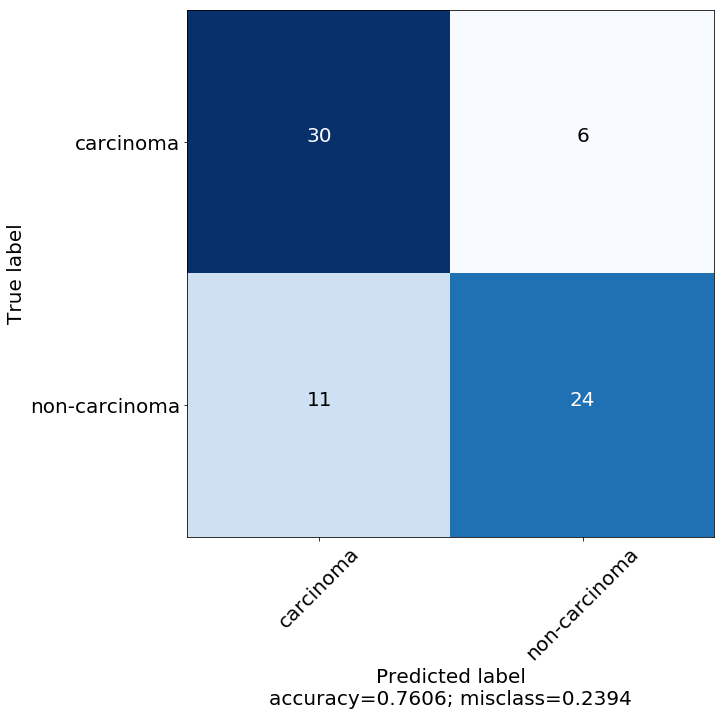

In [19]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[30  6]
 [11 24]]
               precision    recall  f1-score   support

    carcinoma       0.73      0.83      0.78        36
non-carcinoma       0.80      0.69      0.74        35

  avg / total       0.77      0.76      0.76        71



In [21]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  73.17073170731707
Specificity :  80.0


In [22]:
print('roc_auc_score = ' + str(roc_auc_score(predictions, y_true)))

roc_auc_score = 0.7658536585365854


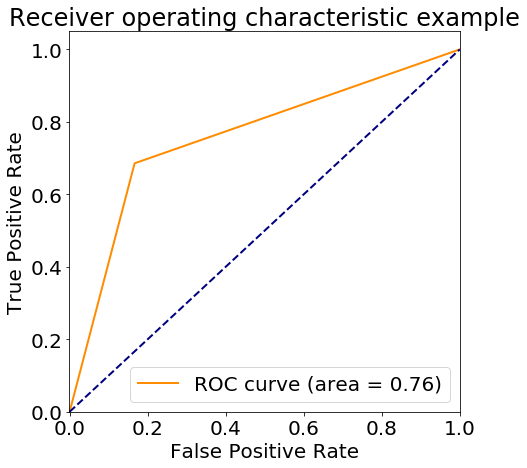

In [23]:
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-.001, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [24]:
predict = model.predict_proba(test_data, batch_size=batch_size, verbose=1)

71/71 [==============================] - 0s 98us/step


In [25]:
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(test_labels, classes=[0, 1])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [26]:
from scipy import interp
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

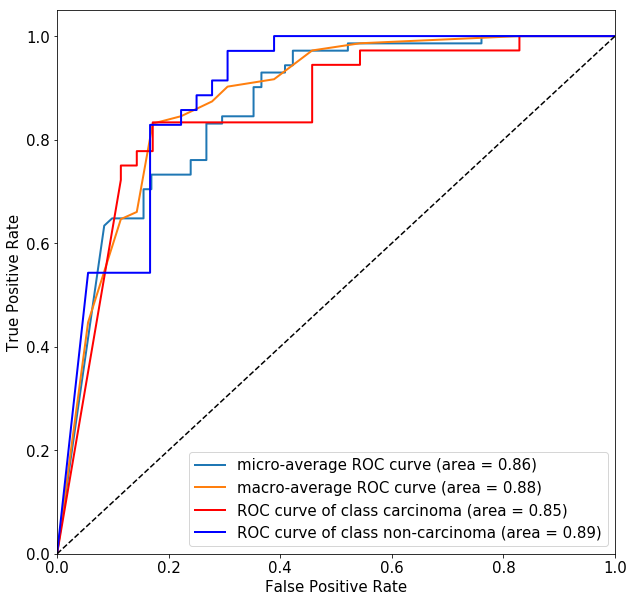

In [27]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from itertools import cycle
classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
    

plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)
plot_name = 'no variation'
colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [28]:
tn, fp, fn, tp = cm.ravel()

In [29]:
print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))
print("Precision:",(tp/(tp+fp)))
print("Recall:",(tp/(tp+fn)))
print("tp:", tp) 
print("fp:", fp) 
print("tn:",tn) 
print("fn:",fn)

Accuracy: 0.7605633802816901
Precision: 0.8
Recall: 0.6857142857142857
tp: 24
fp: 6
tn: 30
fn: 11


In [30]:
print('F1 score:', f1_score(y_true, y_pred))

F1 score: 0.7384615384615385


In [31]:
recall = (tp/(tp+fn))
precision=(tp/(tp+fp))

f1 = 2 / ( (1/recall) + (1 / precision))
print('F1 score:', f1)

F1 score: 0.7384615384615385


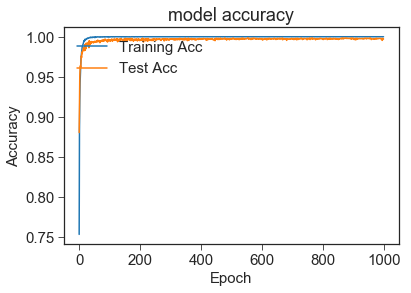

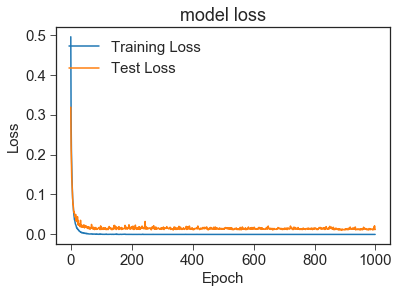

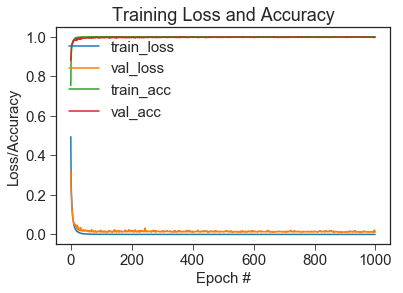

In [32]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")